In [1]:
# Packages used
using Pkg
Pkg.activate("MLJ_environment", shared=true)
using Statistics
using StatsBase: corkendall
using DataFrames
using Queryverse
using VegaLite
using MLJ

# Predicting the Runtime of a Matrix Product

## Objective

The objective is to predict the runtime (milliseconds) of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 261400 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. For this analysis the predictor variable will simply be called runtime and will be aggregated mean of the four runtimes. 

## Data
The data consist of 241600 instances over 15 variables; 14 of which will be used to predict runtime.  Variable descriptions are provided below. 

* The data was loaded from a .csv file called sgemm_product.csv
* A new variable called Runtime was created by averaging the 4 runtimes (Runs)
* Rows were shuffled in preparation of machine learning and statistical analysis

**Variable**|**Data Type**|**Description**
:-----:|:-----:|:-----:
MWG/NWG|Integer|Per-matrix 2D tiling at workgroup level: {16, 32, 64, 128}
KWG|Integer|Inner dimension of 2D tiling at workgroup level: {16, 32} 
MDIMC/NDIMC|Integer|Local workgroup size: {8, 16, 32} 
MDIMA/NDIMB|Integer|Local memory shape: {8, 16, 32} 
KWI|Integer|Kernel loop unrolling factor: {2, 8} 
VWM/VWN|Integer|Per-matrix vector widths for loading and storing: {1, 2, 4, 8} 
STRM/STRN|Categorical|Enable stride for accessing off-chip memory within a single thread: {0, 1} 
SA/SB|Categorical|Per-matrix manual caching of the 2D workgroup tile: {0, 1} 
Run1/Run2/Run3/Run4|Float|Performance times in milliseconds for 4 independent runs using the same parameters
Runtime|Float|The average value of the 4 runtimes

In [2]:
# Show up to 30 columns & 1000 char per line
ENV["COLUMNS"] = 1000;
ENV["LINES"] = 1000

# Load the data and create Runtime variable
data = Queryverse.load("/home/chigball/Data/sgemm_product.csv") |>
@mutate(Runtime = (_.Run1 + _.Run2 + _.Run3 + _.Run4) / 4) |> 
@select(1:14, 19) |> DataFrame

# Shuffle the data
data = data[shuffle(axes(data, 1)), :];

#### Data Preview

The table below is a direct preview of the data.

In [3]:
# Preview the data
data |> @take(10)

10x15 query result
MWG │ NWG │ KWG │ MDIMC │ NDIMC │ MDIMA │ NDIMB │ KWI │ VWM │ VWN │ STRM │ STRN │ SA │ SB │ Runtime
────┼─────┼─────┼───────┼───────┼───────┼───────┼─────┼─────┼─────┼──────┼──────┼────┼────┼────────
128 │ 32  │ 16  │ 8     │ 16    │ 16    │ 8     │ 2   │ 1   │ 1   │ 0    │ 0    │ 1  │ 0  │ 68.39  
64  │ 64  │ 32  │ 8     │ 8     │ 16    │ 8     │ 2   │ 1   │ 1   │ 0    │ 1    │ 0  │ 1  │ 172.368
16  │ 64  │ 16  │ 16    │ 8     │ 8     │ 16    │ 8   │ 1   │ 2   │ 0    │ 0    │ 1  │ 1  │ 44.0675
32  │ 128 │ 32  │ 8     │ 16    │ 32    │ 32    │ 2   │ 1   │ 4   │ 0    │ 1    │ 0  │ 1  │ 71.6575
64  │ 128 │ 32  │ 16    │ 8     │ 16    │ 32    │ 8   │ 1   │ 2   │ 1    │ 1    │ 0  │ 0  │ 263.24 
32  │ 16  │ 32  │ 8     │ 8     │ 8     │ 8     │ 8   │ 1   │ 1   │ 0    │ 0    │ 1  │ 1  │ 83.075 
64  │ 64  │ 16  │ 8     │ 32    │ 32    │ 16    │ 8   │ 2   │ 1   │ 0    │ 1    │ 1  │ 1  │ 23.69  
64  │ 16  │ 32  │ 16    │ 8     │ 8     │ 16    │ 2   │ 1   │ 1   │ 0    │ 0    │ 0  │ 1  │ 129.87 
128 │ 64  │ 32  │ 32    │ 8     │ 8     │ 8     │ 8   │ 2   │ 8   │ 0    │ 1    │ 1  │ 0  │ 44.67  
16  │ 32  │ 32  │ 8     │ 8     │ 16    │ 8     │ 2   │ 1   │ 2   │ 1    │ 1    │ 1  │ 1  │ 51.9975

## Exploration
How is runtime impacted by different features?  This questions will be visualized with a series of circle plots and bar charts.  

In [4]:
# Function to plot circle plots
function circle_plot(m::String, n::String, data::Symbol)
:(
    @vlplot(
    data = $data,
    mark = {:circle, tooltips = true},
    y = {$m, sort = "-y"},
    x = $n,
    size = "mean(Runtime)",
    color =  "mean(Runtime)",
    height = 200,
    width = 200
    )
)
end;

# Function to plot bar plots
function bar_plot(x::String, data::Symbol)
:(
@vlplot(
    data = $data,
    mark = :bar,
    y = "mean(Runtime)",
    x = $x,
    height = 200,
    width = 200
    )  
)   
end;

In [5]:
# Use a random sample of 3000 for plotting
data_ex = data |> @take(3000) |> DataFrame;

# Come up with 8 graphs to plot
p1 = circle_plot("MWG:o", "NWG:o", :data_ex) |> eval;
p2 = circle_plot("MDIMC:o", "NDIMC:o", :data_ex) |> eval;
p3 = circle_plot("MDIMA:o", "NDIMB:o", :data_ex) |> eval;
p4 = circle_plot("VWM:o", "VWN:o", :data_ex) |> eval;
p5 = circle_plot("STRM:o", "STRN:o", :data_ex) |> eval;
p6 = circle_plot("SA:o", "SB:o", :data_ex) |> eval;
p7 = bar_plot("KWG:o", :data_ex) |> eval;
p8 = bar_plot("KWI:o", :data_ex) |> eval;

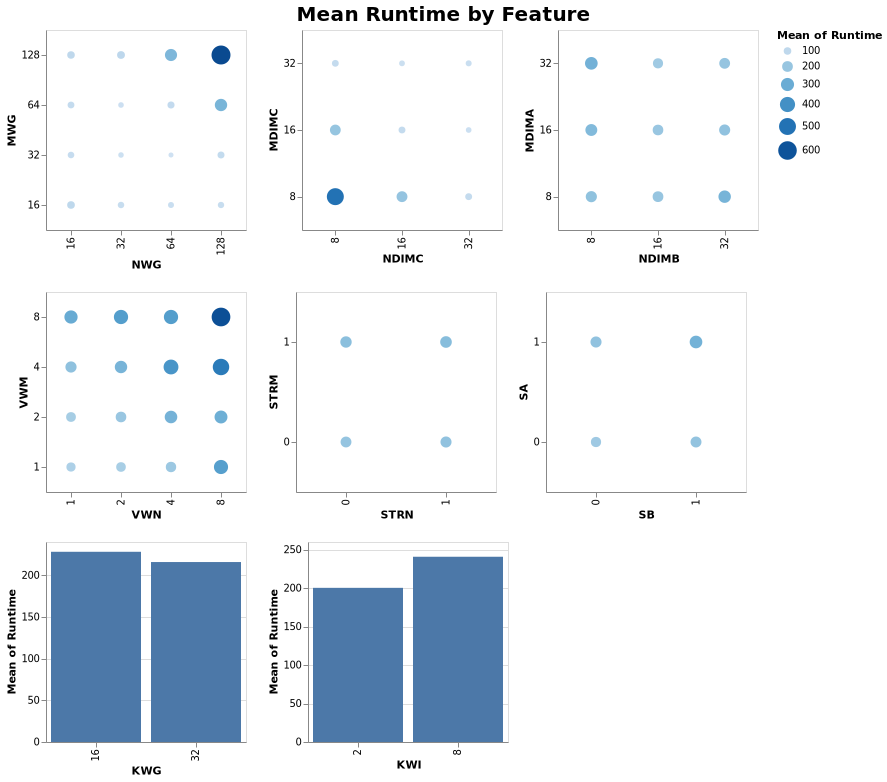

In [6]:
@vlplot(title={text = "Mean Runtime by Feature", fontSize = 20, anchor = "middle"}) + 
[[p1 p2 p3] ; [p4 p5 p6] ; [p7 p8]]

Judging from the charts, it appears that MWG/NWG, MDIMC/NDIMC, and VWM/VWN are impactful variables.  Variable importance will also be revisited via the regression tree via modeling. 

## Model Building

The data was split into a training and testing set (70/30) and a EvoTree Regressor model built to predict runtime, initially using a max_dept of 8 and nrounds of 10.  The schema of the data is described below.  

In [7]:
# Select X and y for modeling
X = data |> @select(-:Runtime) |> DataFrame;
y = data.Runtime;
schema(X)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ MWG     │ Int64   │ Count      │
│ NWG     │ Int64   │ Count      │
│ KWG     │ Int64   │ Count      │
│ MDIMC   │ Int64   │ Count      │
│ NDIMC   │ Int64   │ Count      │
│ MDIMA   │ Int64   │ Count      │
│ NDIMB   │ Int64   │ Count      │
│ KWI     │ Int64   │ Count      │
│ VWM     │ Int64   │ Count      │
│ VWN     │ Int64   │ Count      │
│ STRM    │ Int64   │ Count      │
│ STRN    │ Int64   │ Count      │
│ SA      │ Int64   │ Count      │
│ SB      │ Int64   │ Count      │
└─────────┴─────────┴────────────┘
_.nrows = 241600


The schema suggest a need for a Count to Continous conversion for an EvoTree ML pipeline, since EvoTree only accepts Continous datatypes for its input.  

In [8]:
# Create an index for model and validation sets
m, v = partition(eachindex(y), 0.7, shuffle=true);

# Create model/training sets
Xm = X[m,:]
ym = y[m]

# Create validation/testing sets
Xv = X[v,:]
yv = y[v]

# load EvoTreeRegressor model
Tree = @load EvoTreeRegressor pkg="EvoTrees"

# Create pipeline that converts inputs into continous and fits an EvoTreeRegressor
pipe = @pipeline(
    X -> coerce(X, Count => Continuous),
    Tree(max_depth = 8),
    prediction_type = :deterministic
);

# Fit machine
mach = machine(pipe, Xm, ym) |> fit!

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/chigball/.julia/packages/MLJModels/9mQfs/src/loading.jl:168


import EvoTrees ✔


┌ Info: Training Machine{Pipeline265,…} @115.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Training Machine{EvoTreeRegressor{Float64,…},…} @808.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342


Machine{Pipeline265,…} @115 trained 1 time; caches data
  args: 
    1:	Source @217 ⏎ `Table{AbstractVector{Count}}`
    2:	Source @443 ⏎ `AbstractVector{Continuous}`


In [9]:
# Current model
pipe

Pipeline265(
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 8,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(444, (0, 1691376, 1690374, 966)),
            device = "cpu")) @638

## Cross Validation & Model Tuning

The number of rounds of training (nrounds) and maximum tree dept (max_dept) was plotted as learning curves.  At nrounds = 80 and max_dept = 14 the root mean squared error (rms) was minimized.  As a result the machine was refitted with these parameters. 

In [10]:
# Function to plot learning curves
function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    title = "Learning Curve",
    height = 250,
    width = 260
  )  
end;

In [11]:
# Generate learning curve
r1 = range(pipe, :(evo_tree_regressor.nrounds); values = 1:20:120)
curve1 = learning_curve(mach; range=r1, resampling = Holdout(), measure = rms)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…} @710.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Attempting to evaluate 6 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/rh0Y9/src/tuned_models.jl:564
Evaluating over 6 metamodels: 100%[=========================] Time: 0:00:17


(parameter_name = "evo_tree_regressor.nrounds",
 parameter_scale = :none,
 parameter_values = [1, 21, 41, 61, 81, 101],
 measurements = [333.4784462333766, 73.31891570781735, 43.55810864343822, 35.9929981911477, 34.26080603680237, 33.270771799035735],)

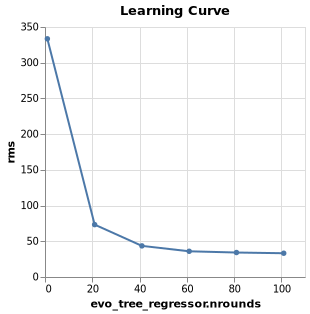

In [12]:
# Plot learning curve
p1 = plot_lc(curve1, "rms")

In [13]:
# Change nrounds parameter to 80
pipe.evo_tree_regressor.nrounds = 80

# Refit machine
mach = machine(pipe, Xm, ym) |> fit!

┌ Info: Training Machine{Pipeline265,…} @628.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Training Machine{EvoTreeRegressor{Float64,…},…} @415.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342


Machine{Pipeline265,…} @628 trained 1 time; caches data
  args: 
    1:	Source @380 ⏎ `Table{AbstractVector{Count}}`
    2:	Source @903 ⏎ `AbstractVector{Continuous}`


In [14]:
# Generate learning curve
r2 = range(pipe, :(evo_tree_regressor.max_depth); values = 1:16)
curve2 = learning_curve(mach; range=r2, resampling = Holdout(), measure = rms)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…} @357.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Attempting to evaluate 16 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/rh0Y9/src/tuned_models.jl:564
Evaluating over 16 metamodels: 100%[=========================] Time: 0:01:37


(parameter_name = "evo_tree_regressor.max_depth",
 parameter_scale = :none,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 measurements = [368.1009442411043, 287.5885827478598, 235.1028127452507, 178.9156739224915, 130.42517405670637, 91.81890107454974, 57.37436053998194, 34.317814510864864, 22.20122399782402, 16.852480334730004, 13.15889492116789, 10.597085423341163, 8.36324881606698, 6.766373849467958, 6.047680575123433, 5.783165382599486],)

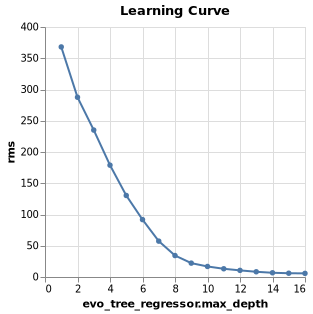

In [15]:
# Plot learning curve
p2 = plot_lc(curve2, "rms")

In [16]:
# Change nrounds parameter to 14
pipe.evo_tree_regressor.max_depth = 14

# Refit machine
mach = machine(pipe, Xm, ym) |> fit!

┌ Info: Training Machine{Pipeline265,…} @559.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Training Machine{EvoTreeRegressor{Float64,…},…} @193.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342


Machine{Pipeline265,…} @559 trained 1 time; caches data
  args: 
    1:	Source @039 ⏎ `Table{AbstractVector{Count}}`
    2:	Source @286 ⏎ `AbstractVector{Continuous}`


## Model Evaluation 

Evaluation was done using the metrics rms and mae with 70% shuffled resampling.  The error values for rms and mae are described below.  

In [17]:
# Model Evaluation on test data
yp = collect(predict(mach, Xv))
RMS = round(rms(yp, yv), digits = 3) 
COR = round(Statistics.cor(yp, yv), digits = 8) 

# Model Evaluation
evaluate!(mach, 
  resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
  measures=[rms, mae],
  verbosity = 0
)

┌───────────────────────────┬───────────────┬────────────┐
│ _.measure                 │ _.measurement │ _.per_fold │
├───────────────────────────┼───────────────┼────────────┤
│ RootMeanSquaredError @376 │ 6.6           │ [6.6]      │
│ MeanAbsoluteError @947    │ 2.89          │ [2.89]     │
└───────────────────────────┴───────────────┴────────────┘
_.per_observation = [missing, missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]
_.train_test_rows = [ … ]


In [18]:
println("A rms error of $(RMS) and a correlation of $(COR) was also achieved for the test set between predicted and observed values.")

A rms error of 6.023 and a correlation of 0.99986545 was also achieved for the test set between predicted and observed values.


## Feature Importance

Feature selection was done using EvoTree's normalized gain by feature.  The most important variables are shown below.  

In [19]:
# A function to extract the feature importance from a mach object of an evotree classifier
function Importance(mach::Machine)
    df = report(mach).evo_tree_regressor |> DataFrame |>
    @mutate(Feature = first.(_.feature_importances)) |>
    @mutate(Importance = last.(_.feature_importances)) |>
    @mutate(Importance = round.(_.Importance, digits = 2)) |>
    @filter(_.Importance > 0) |> 
    @select(:Feature, :Importance) |> 
    @vlplot(
        x = "Importance:q",
        y = {"Feature:n", sort = "-x"},
        mark = {:bar, tooltops = true},
        height = 300,
        title = "Feature Importance Ranking"    
    )
end;

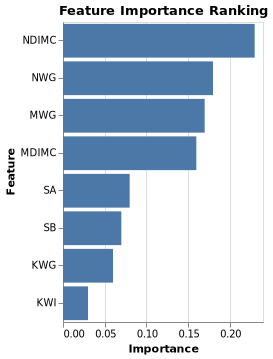

In [20]:
# Plot the feature importance ranking
Importance(mach)

The EvoTree model found MWG/NWG and MDIMC/NDIMC to be important predictor variables.  Surprisingly SA/SB are also adequate predictors despite them seeming irrelevant in the earlier data visualization.  

## Conclusion

The runtime of the matrix product (A * B) was found to be most dependent on the variables MWG/NWG and MDIMC/NDIMC but to a lesser extent SA/SB.  A higher MWG/NWG and a lower MDIMC/NDIMC reduced the runtime of matrix multiplication.  The EvoTree model regression model was also optimized when when nrounds and max_dept parameters was set to around 80 and 14 respectively. 

## References

* Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola. Sobol Tensor Trains for Global Sensitivity Analysis. In arXiv Computer Science / Numerical Analysis e-prints, 2017 (https://128.84.21.199/abs/1712.00233).

* Cedric Nugteren and Valeriu Codreanu. CLTune: A Generic Auto-Tuner for OpenCL Kernels. In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015 (http://ieeexplore.ieee.org/document/7328205/)